# Project Sentiment analysis

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

### Цель проекта
- **Обучить модель классифицировать комментарии на позитивные и негативные. Имеется набор данных с разметкой о токсичности правок.**

- **Важные критерии:**
    - Метрика качества *F1* не меньше 0.75.

### Этапы:

#### [1. Обзор данных](#load)
- **Загрузить и проанализировать входные данные**

#### [2. Предобработка](#data_preprocessing)
- **Выявить проблемы с данными**

#### [3. Моделирование](#model)
- **Векторизовать текст с помощью TF-IDF**
- **Создать эмбеддинг с помощью BERT**
- **Построить pipeline для выбора модели и гиперпарамиетров**
- **Провести подбор гиперпараметров моделей LogisticRegression, RandomForestClassifier, MultinomialNB, LinearSVC**
- **Оценить F1 лучшей модели**
- **Интерпретировать результаты**

#### [4. Выводы](#conclusion)

## Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Импорт библиотек

In [1]:
%pip install -U -q scikit-learn
%pip install -q torch
%pip install -q transformers
%pip install -q datasets

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [2]:
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2
%pip install Pillow==8.0.0

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [3]:
import os
import re
import warnings

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import transformers
import wordcloud
from datasets import Dataset
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC
from tqdm import notebook
from transformers import BertModel, BertTokenizer
from wordcloud import WordCloud

# Настройка
RANDOM_STATE = 42
TEST_SIZE = 0.25
_model = None
_tokenizer = None

# Используем GPU, если доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA доступен:", torch.cuda.is_available())
print("Имя устройства:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA доступен: False
Имя устройства: CPU


In [4]:
# задаем настройки pandas
pd.set_option('display.float_format', '{:.4f}'.format)

# задаем настройки среды визуализации
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline

set_config(display="diagram")

warnings.filterwarnings('ignore')

In [5]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data] 

True

<a id="load"></a>
## Обзор данных

In [6]:
# загружаем датасеты
pth = '/datasets/toxic_comments.csv'
pth_alt = r"C:\Users\User\da_practicum\local_projects\12.2 Проект Викишоп\data\toxic_comments.csv"
pth_alt_2 = r"/content/toxic_comments.csv"

if os.path.exists(pth):
    raw_data = pd.read_csv(pth, index_col=[0])
elif os.path.exists(pth_alt):
    raw_data = pd.read_csv(pth_alt, index_col=[0])
elif os.path.exists(pth_alt_2):
    raw_data = pd.read_csv(pth_alt_2, index_col=[0])
else:
    print('Something is wrong')
    raw_data = None
raw_data = raw_data.reset_index(drop=True)
raw_data.shape

(159292, 2)

In [7]:
# определим функцию для вывода общей информации о датасете
def displ_data(data, title='Обзорная информация'):
    """
    Функция для вывода общей информации о датасете
    """

    print(f'----------{title}----------\n')

    display(data.info())

    print(f'-------Датафрейм-------\n')
    display(data.head(5))

    plt.figure(figsize=(8, 9))
    plt.pie(data['toxic'].value_counts(),
        labels=['Non-toxic (0)', 'Toxic (1)'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'salmon'])
    plt.title('Баланс классов', fontsize=12)
    plt.show()

    #определене пропусков
    print(f'-------Количество пропусков-------\n')
    print(data.isna().sum())

----------Обзорная информация----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

-------Датафрейм-------



,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


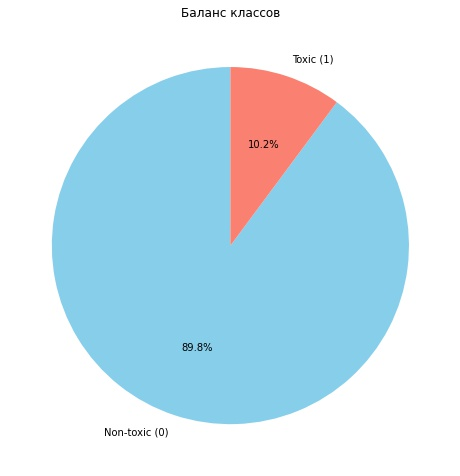

-------Количество пропусков-------

text     0
toxic    0
dtype: int64


In [8]:
displ_data(raw_data)

- ***Вывод по обзору: в данных наблюдается дисбаланс классов - токсичных комментариев 10%. В моделях будем использовать стратификацию. Пропусков в данных нет.***

<a id="data_preprocessing"></a>
## Предобработка
- **Предобработку текста будем делать в пайплайне.**

In [9]:
# список стоп слов
stopwords = list(set(nltk_stopwords.words('english')))

In [10]:
# для ускорения работы в тестовом режиме
# оставим стратифицированную выборку из 3000 семплов
data = (raw_data
        .groupby('toxic', group_keys=False)
        .apply(lambda x: x.sample(frac=0.02, random_state=RANDOM_STATE)))

----------Обзорная информация----------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186 entries, 145800 to 76903
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3186 non-null   object
 1   toxic   3186 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 74.7+ KB


None

-------Датафрейм-------



,text,toxic
145800,"Press \n June 2011: Today Show, NBC: Today's M...",0
41036,Contested deletion \n\nThis article should not...,0
127525,"""\n Your latest edits have goen even further ...",0
5828,"""\nIt should not be deleted, but fixed. North ...",0
87746,I'm back... \n\n...I haven't found the rusty k...,0


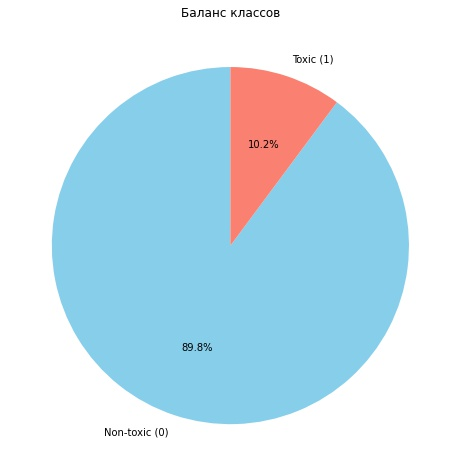

-------Количество пропусков-------

text     0
toxic    0
dtype: int64


In [11]:
displ_data(data)

### Функции очистки и лемматизации текста

In [12]:
def clear_text(text, pattern=r'[^a-zA-Z]'):
    """
    Функция для очистки текста.
    Удаляет все символы кроме букв латинского алфавита.
    """
    return " ".join(re.sub(pattern, ' ', text).split()).lower()

In [13]:
def get_wordnet_pos(nltk_pos_tag):
    """
    Функция для определения части речи. Используется в функции лемматизации
    """
    if nltk_pos_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_pos_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def lemmatize_txt(text):
    """
    Функция для лемматизации текста (строки)
    """

    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)  # [(word, pos_tag), ...]

    lemmatized_words = []
    for word, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag)
        lemmatized = lemmatizer.lemmatize(word, pos=wordnet_pos)
        lemmatized_words.append(lemmatized)

    return " ".join(lemmatized_words)

In [15]:
def lemmatize_df(X):
    """
    Функция для лемматизации датафрейма
    """
    if isinstance(X, pd.DataFrame):
        X = X.iloc[:, 0]

    X_ = X.apply(clear_text)
    X_ = X_.apply(lemmatize_txt)

    return X_

### Облако слов

In [16]:
clear_data_toxic = str(lemmatize_df(data.loc[data['toxic']==1]).tolist())
clear_data = str(lemmatize_df(data.loc[data['toxic']==0]).tolist())

In [17]:
def plot_cloud(wordcloud, title):
    """
    Функция для построения облака слов
    """
    plt.figure(figsize=(10, 7))  
    plt.imshow(wordcloud)
    plt.title(title, fontsize=17)
    plt.axis("off")

In [18]:
dejavu_path = fm.findfont(fm.FontProperties(family="DejaVu Sans"))

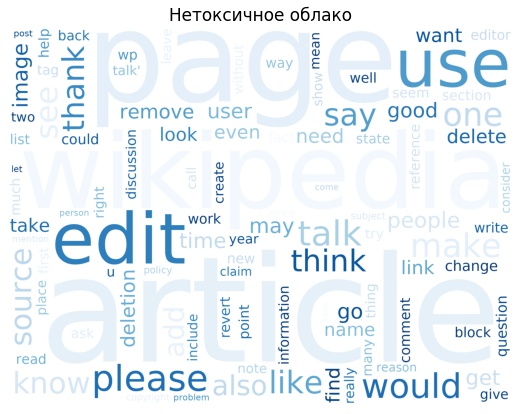

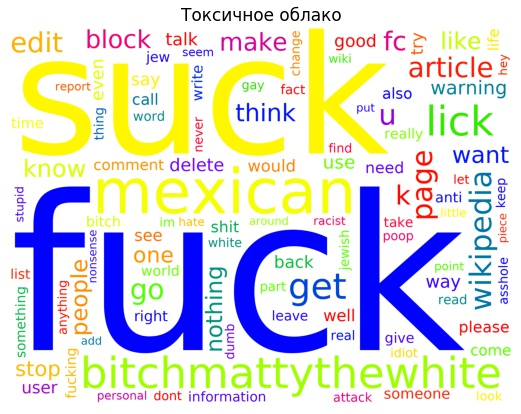

In [19]:
wordcloud = WordCloud(width = 2000, 
                      height = 1500,
                      random_state=RANDOM_STATE, 
                      background_color='white',
                      font_path=dejavu_path,
                      margin=20, 
                      colormap='Blues', 
                      collocations=False,
                      max_words=100,
                      stopwords = stopwords).generate(clear_data)

wordcloud_toxic = WordCloud(width = 2000, 
                      height = 1500,
                      random_state=RANDOM_STATE, 
                      background_color='white',
                      font_path=dejavu_path,
                      margin=20, 
                      colormap='prism', 
                      collocations=False,
                      max_words=100,
                      stopwords = stopwords).generate(clear_data_toxic)


plot_cloud(wordcloud, "Нетоксичное облако")
plot_cloud(wordcloud_toxic, "Токсичное облако")

- ***Токсичные комментарии не зря получили такую оценку.***

### Функции вычисления эмбеддингов BERT

In [20]:
def load_model(model_name="bert-base-uncased"):
    """
    Функция для загрузки модели и токенайзера
    """
    global _model, _tokenizer

    if _model is None or _tokenizer is None:
        print("Загружаем BERT и токенайзер...")
        try:
            _tokenizer = BertTokenizer.from_pretrained(model_name)
        except:
            _tokenizer = transformers.BertTokenizer(
                        vocab_file='/datasets/ds_bert/vocab.txt')

        _model = BertModel.from_pretrained(model_name)
        _model.to(device)
        _model.eval()

    return _model, _tokenizer

In [21]:
def calculate_embaddings(model, padded, attention_mask, X):
    """
    Функция для вычисления эмбеддингов
    """
    batch_size = 50
    embeddings = []

    for i in notebook.tqdm(range(0, padded.shape[0], batch_size)):
        # если есть возможность, переносим на GPU
        batch_end = min(i + batch_size, padded.shape[0])
        batch = torch.LongTensor(padded[i:batch_end]).to(device)
        attention_mask_batch = (torch
                                .LongTensor(attention_mask[i:batch_end])
                                .to(device))

        with torch.no_grad():
            outputs = model(batch, attention_mask=attention_mask_batch)
            cls_embeddings = outputs.pooler_output

        embeddings.append(cls_embeddings.cpu().numpy())

    # проверка
    if len(embeddings) == 0:
        return np.zeros((X.shape[0], 768))
    embeddings = np.vstack(embeddings)

    if embeddings.shape[0] != X.shape[0]:
        raise ValueError(f"Embedding shape mismatch: expected \
         {X.shape[0]} samples, got {embeddings.shape[0]}")

    return embeddings

In [22]:
def bert_embeddings(X):
    """
    Функция для вычисления эмбеддингов
    """

    # загружаем модель и токенайзер
    model, tokenizer = load_model()

    # проверка входных данных. приведение к датафрейму
    if isinstance(X, pd.Series):
        X = pd.DataFrame({'text': X})
    elif isinstance(X, pd.DataFrame):
        X = X.copy()
    else:
        return np.zeros((1, 768))

    def tokenize_func(df):
        """
        Функция для токенизации текста (строки)
        """
        return tokenizer(df['text'],
                            padding='max_length',
                            truncation=True,
                            max_length=100)

    dataset = Dataset.from_pandas(X[['text']])

    tokenized_df = dataset.map(tokenize_func, batched=True)
    tokenized_df = tokenized_df.remove_columns(['text'])

    padded = np.asarray(tokenized_df['input_ids'])
    attention_mask = np.asarray(tokenized_df['attention_mask'])

    # ввычисляем эмбеддинги
    embeddings = calculate_embaddings(model, padded, attention_mask, X)

    return embeddings

<a id="model"></a>
## Моделирование

- **Пропишем пайплайн, функцию подбора гиперпараметров.**

In [23]:
def make_pipeline(df, target, tfidf=True, bert=False):

    '''
    Функция готовит пайплпйн
    '''

    corpus = df[['text']]
    y = df[target]

    corpus_train, corpus_test, y_train, y_test = train_test_split(
        corpus, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # tfidf - по умолчанию
    if tfidf:

        # лемматизация текста
        corpus_train, corpus_test = (
            lemmatize_df(corpus_train),
            lemmatize_df(corpus_test)
        )

        # финальный пайплайн
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=stopwords,
                                      ngram_range=(1, 1),
                                      sublinear_tf=True)),
            ('models', LogisticRegression(random_state=RANDOM_STATE))
        ])

    # bert
    elif bert:

        # вычисляем эмбеддинги
        corpus_train, corpus_test = (
            bert_embeddings(corpus_train),
            bert_embeddings(corpus_test)
        )

        # финальный пайплайн
        pipe = Pipeline(
            [('models', LogisticRegression(random_state=RANDOM_STATE))]
        )

    return pipe, corpus_train, corpus_test, y_train, y_test

In [24]:
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def searchCV(pipe, param_grid, corpus_train, y_train, n_jobs):
    """
    Функция для подбора гиперпараметров и выбора модели
    """
    search = RandomizedSearchCV(
        pipe,
        param_grid,
        cv=stratified_cv,
        scoring='f1_weighted',
        n_jobs=n_jobs,
        n_iter=100,
        verbose=1,
        pre_dispatch='2*n_jobs',
        random_state=RANDOM_STATE
    )

    search.fit(corpus_train, y_train)

    return search

In [25]:
param_grid_tfidf = [
    #LinearSVC
    {
        'models': [LinearSVC(class_weight='balanced',
                             random_state=RANDOM_STATE)],
        'models__C': np.logspace(-2, 2, 20).tolist(),
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_df': [0.9, 0.925, 0.95, 0.975, 1.0],
        'tfidf__binary': [True, False]
    },
    #LogisticRegression
    {
        'models': [LogisticRegression(class_weight='balanced',
                                      random_state=RANDOM_STATE,
                                      solver='saga')],
        'models__C': np.logspace(-2, 2, 20).tolist(),
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_df': [0.9, 0.925, 0.95, 0.975, 1.0],
        'tfidf__binary': [True, False]
    },
    # RandomForest
    {
        'models': [RandomForestClassifier(class_weight='balanced',
                                          random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__max_depth': [None, 10, 20, 30],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_df': [0.9, 0.925, 0.95, 0.975, 1.0],
        'tfidf__binary': [True, False]
    },
    # MultinomialNB
    {
        'models': [MultinomialNB()],
        'models__alpha': np.logspace(-2, 1, 20).tolist(),
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_df': [0.9, 0.925, 0.95, 0.975, 1.0],
        'tfidf__binary': [True, False]
    }
]

In [40]:
param_grid_bert = [
   #LinearSVC
    {
        'models': [LinearSVC(class_weight='balanced',
                             random_state=RANDOM_STATE,
                             max_iter=10000)],
        'models__C': np.logspace(-2, 2, 20).tolist()
    },
    #LogisticRegression
    {
        'models': [LogisticRegression(class_weight='balanced',
                                      random_state=RANDOM_STATE,
                                      max_iter=1000,
                                      solver='saga')],
        'models__C': np.logspace(-2, 2, 20).tolist()
    },
    # RandomForest
    {
        'models': [RandomForestClassifier(class_weight='balanced',
                                          random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__max_depth': [None, 10, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
    }
]

In [27]:
def result_tab(search):
    """
    Функция выводит таблицу с лучшими выбранными моделями и их скорами
    """
    result = pd.DataFrame(search.cv_results_)

    result['model_name'] = (result['param_models']
                            .apply(lambda x: str(x)
                            .split('(')[0]))

    best_results = (result[['model_name', 'mean_test_score']]
                    .groupby('model_name')
                    .agg('max')
                    .sort_values('mean_test_score', ascending=False))

    best_results = best_results.rename(columns={
        'mean_test_score': 'F1'
    })

    return best_results.abs()

- ***Пайплайн для TF-IDF***

In [28]:
(pipe_tfidf,
 corpus_train_tfidf,
 corpus_test_tfidf,
 y_train_tfidf,
 y_test_tfidf) = make_pipeline(data,
                               'toxic',
                               tfidf=True,
                               bert=False)
(corpus_train_tfidf.shape,
 y_train_tfidf.shape,
 corpus_test_tfidf.shape,
 y_test_tfidf.shape)

((2389,), (2389,), (797,), (797,))

- ***Пайплайн для BERT***

In [29]:
(pipe_bert,
 corpus_train_bert,
 corpus_test_bert,
 y_train_bert,
 y_test_bert) = make_pipeline(data,
                              'toxic',
                              tfidf=False,
                              bert=True)
(corpus_train_bert.shape,
 y_train_bert.shape,
 corpus_test_bert.shape,
 y_test_bert.shape)

Загружаем BERT и токенайзер...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/2389 [00:00<?, ? examples/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Map:   0%|          | 0/797 [00:00<?, ? examples/s]

  0%|          | 0/16 [00:00<?, ?it/s]

((2389, 768), (2389,), (797, 768), (797,))

### Подбор гиперпараметров моделей и TfidfVectorizer

In [30]:
search = searchCV(pipe_tfidf,
                  param_grid_tfidf,
                  corpus_train_tfidf,
                  y_train_tfidf,
                  n_jobs=-1)
print('---Таблица результатов---')
result_tab(search)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
---Таблица результатов---


,F1
model_name,
LogisticRegression,0.9325
LinearSVC,0.9313
RandomForestClassifier,0.9149
MultinomialNB,0.9134


In [49]:
print('---Параметры лучшей модели---')
search.best_params_

---Параметры лучшей модели---


{'tfidf__ngram_range': (1, 1),
 'tfidf__max_df': 0.95,
 'tfidf__binary': False,
 'models__C': 3.359818286283781,
 'models': LogisticRegression(class_weight='balanced', random_state=42, solver='saga')}

### Подбор гиперпараметров моделей с BERT

In [41]:
search_bert = searchCV(pipe_bert,
                       param_grid_bert,
                       corpus_train_bert,
                       y_train_bert,
                       n_jobs=-1)
print('---Таблица результатов---')
result_tab(search_bert)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
---Таблица результатов---


,F1
model_name,
LogisticRegression,0.9069
LinearSVC,0.9034
RandomForestClassifier,0.8907


In [42]:
print('---Параметры лучшей модели---')
search_bert.best_params_

---Параметры лучшей модели---


{'models__C': 23.357214690901213,
 'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                    solver='saga')}

### F1 лучшей модели на тестовой выборке

In [53]:
def best_model_score():
    """
    Функция выбирает лучшую модель по результатам кросс-валидации, вычисляет метрику на тестовой выборке
    """
    if result_tab(search).iat[1, 0] > result_tab(search_bert).iat[1, 0]:
        pipe_final_best = search.best_estimator_

        display(pipe_final_best.fit(corpus_train_tfidf, y_train_tfidf))

        y_pred = pipe_final_best.predict(corpus_test_tfidf)
        f1 = f1_score(y_test_tfidf, y_pred, average='weighted')

        best_model = str(search.best_estimator_["models"]).split('(')[0]
        
        print(f'F1 модели {best_model} с TF-IDF на тестовой выборке: {round(f1, 3)}')
        y_test = y_test_tfidf
    else:
        pipe_final_best = search_bert.best_estimator_

        pipe_final_best.fit(corpus_train_bert, y_train_bert)

        y_pred = pipe_final_best.predict(corpus_test_bert)
        f1 = f1_score(y_test_bert, y_pred, average='weighted')

        best_model = str(search_bert.best_estimator_["models"]).split('(')[0]
        
        print(f'F1 модели {best_model} c BERT на тестовой выборке: {round(f1, 3)}')
        y_test = y_test_bert
    return y_test, y_pred

In [44]:
y_test, y_pred = best_model_score()

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95,
                                 stop_words=['below', 'theirs', 'herself',
                                             'mustn', "couldn't", 'did', 'don',
                                             "haven't", "won't", "you're",
                                             "i'll", 'same', 'couldn', 'just',
                                             "she'd", 'ours', 'more', 't',
                                             'off', 'such', 'himself', 'were',
                                             'mightn', 'other', 'has', 'down',
                                             'shan', 'm', 's', 'those', ...],
                                 sublinear_tf=True)),
                ('models',
                 LogisticRegression(C=3.359818286283781,
                                    class_weight='balanced', random_state=42,
                                    solver='saga'))])

F1 модели LogisticRegression с TF-IDF на тестовой выборке: 0.935


### Анализ результатов

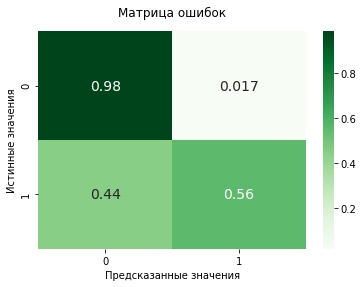

In [50]:
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'),
            annot=True,
            cmap='Greens',
            annot_kws={'fontsize': 14})

plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

***Модель точно предсказывает нейтральные комментарии. В 44% случаев определяет токсичный комментарий как нейтральный. Скорее всего это связанно с дисбалансом классов, и что для теста использовалась не полная выборка.***


***В итоге модель LogisticRegression с TF-IDF показала лучший результат на кросс валидации. Опять же это может быть связано с выбором параметров токенизации, недостаточным набором данных для получения точный эмбеддингов у модели с BERT***

<a id="conclusion"></a>
## Вывод

1. **Получены данные с комментариями и целевым признаком - токсичный/нетоксичный этот коментарий. Данные без пропусков, есть дисбаланс классов (токсичных комментариев меньше).**


2. **Выбрано 2 пути предобработки текста:**
    - **В качестве бейзлайна TF-IDF vectorizer + LogisticRegression. (Проведена очиста текста, лемматизация)**
    - **Другой путь - получение эмбеддингов на предобученном BERT + LogisticRegression. (Для получения эмбеддингов текст не обрабатывался)**
    

3. **Отображены 2 облака слов для токсичного и нейтрального классов.**


4. **Проведен подбор гиперпараметров моделей. Результаты на кросс валидации:**

In [51]:
print('---F1 score для моделей с TF-IDF---')
result_tab(search)

---F1 score для моделей с TF-IDF---


,F1
model_name,
LogisticRegression,0.9325
LinearSVC,0.9313
RandomForestClassifier,0.9149
MultinomialNB,0.9134


In [52]:
print('---F1 score для моделей с BERT---')
result_tab(search_bert)

---F1 score для моделей с BERT---


,F1
model_name,
LogisticRegression,0.9069
LinearSVC,0.9034
RandomForestClassifier,0.8907


In [48]:
y_test, y_pred = best_model_score()

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95,
                                 stop_words=['below', 'theirs', 'herself',
                                             'mustn', "couldn't", 'did', 'don',
                                             "haven't", "won't", "you're",
                                             "i'll", 'same', 'couldn', 'just',
                                             "she'd", 'ours', 'more', 't',
                                             'off', 'such', 'himself', 'were',
                                             'mightn', 'other', 'has', 'down',
                                             'shan', 'm', 's', 'those', ...],
                                 sublinear_tf=True)),
                ('models',
                 LogisticRegression(C=3.359818286283781,
                                    class_weight='balanced', random_state=42,
                                    solver='saga'))])

F1 модели LogisticRegression с TF-IDF на тестовой выборке: 0.935


5. **F1 мера удовлетворяет условию заказчика >0.75. Модель довольно точно классифицирует нейтральные комментарии. Однако часто ошибается при классификации токсичных комментариев.**


6. **Варианты для улучшения модели:**
    - ***Обучить модель на большем наборе данных "как есть". Займет больше времени, потребуется использование GPU.***
    - ***Подобрать более сложную модель вместо логистической регрессии - использовать нейросеть на выходном слое.***
    - ***Провести fine-tuning BERT. Это даст самый значительный прирост, однако потребуется еще больше ресурсов, чем в 1 случае.***